<a href="https://colab.research.google.com/github/danielbauer1979/ML_656/blob/main/Assignment6_RandomForestsAndBoosting_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forests and Boosting

Application in the context of the wine data set. Let's see if we can beat the logistic regression model using random forests and/or gradient boosting.

Let's start again with loading the required packages. Now the versatility of SkLearn may become clear: it includes all these learners, and the implementation is quite similar to the previous, simpler algorirhms.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import graphviz
import pydot
from io import StringIO

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc

## Data Retrieval

Let's again load the wine data set:

In [2]:
!git clone https://github.com/danielbauer1979/ML_656.git

Cloning into 'ML_656'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 305 (delta 108), reused 123 (delta 76), pack-reused 117
Receiving objects: 100% (305/305), 26.30 MiB | 8.13 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [3]:
wine = pd.read_csv('ML_656/winequality-red.csv', sep = ';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


And, as before, let's recast as a classification problem for high quality wines (above 6 quality ranking) and lower quality wines (six and below):

In [4]:
wine['quality'] = wine['quality'] > 6
wine['quality'].describe()

count      1599
unique        2
top       False
freq       1382
Name: quality, dtype: object

And, as we are used to by now, we are splitting the data into *three* sets. The idea is that we will use the training set for, yes, training; the validation set for tuning our parameters; and then the test set for assessing and comparing the final models.

Here, we also scale/standardize the data. Notice that we did not do that in the case of trees, and since the random forest, say, is just a bunch of trees scaling isn't necessary. Yet, as we also said before, there isn't really a downside to scaling, so let's just do it. I scale based on the `X_train` set, and then apply the same scaler for all data.

In [5]:
np.random.seed(42)
train, test = train_test_split(wine, test_size = 0.5)
val, test = train_test_split(test, test_size = 0.5)
X_train = train.drop(columns = ['quality']).values
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
y_train = train['quality'].values
X_val = val.drop(columns = ['quality']).values
X_val = scaler.transform(X_val)
y_val = val['quality'].values
X_test = test.drop(columns = ['quality']).values
X_test = scaler.transform(X_test)
y_test = test['quality'].values

###Baseline: Logistic Regression

Let's run the logistic regression model as a baseline. Here we use the training test for training the model and the test set for evaluating the classifier via the AUC. Note that we could use the validation set to select variables, but we will limit our analysis to the full model with all features as the baseline.

Let's fit the model:

In [6]:
logistic_model = LogisticRegression(fit_intercept=True, max_iter=1000).fit(X_train,y_train)

Let's predict (recall that for the ROC curve we need to predit probabilities!):

In [7]:
logistic_pred_test = logistic_model.predict_proba(X_test)

And let's evaluate the ROC curve:

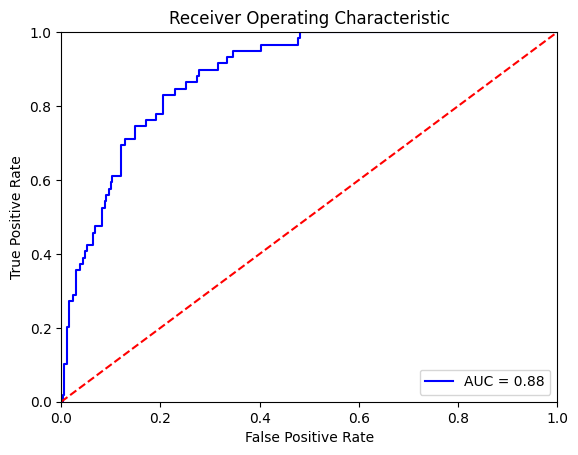

In [8]:
fpr, tpr, threshold = roc_curve(y_test, logistic_pred_test[:,1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [9]:
confusion_matrix(y_test, (logistic_pred_test[:,1] > 0.5))

array([[328,  13],
       [ 38,  21]])

So we obtain an AUC of 88%. One thing to mention: The performance is somewhat sensitive to the data split. If we set the seed to 101, for example, the AUC in the test set decreases to 82%. It's helpful to experiment a little just to make sure we are capturing adequate results...

### Random Forest

Next, let's run with the random forest. We will start by using the default parameters, and will evaluate them in the test set:

In [10]:
wine_rf_base = RandomForestClassifier(random_state=1)
wine_rf_base.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [12]:
wine_rf_base_pred = wine_rf_base.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, wine_rf_base_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.8937571449873254

In [ ]:
confusion_matrix(test['quality'], (wine_rf_base_pred > 0.5))

array([[328,  13],
       [ 31,  28]])

So a bit better than the logistic regression model. And it turns out that this increase in performance sustains if we change the data a bit. For instance, if we go to the 101 seed, we still have an 88% AUC. Also noteworthy is the fact that we didn't need to tune at all to get a pretty decent performance.

 Bt, let's see if we can improve performance just a bit by tuning a bit. Let's try variants with more and fewer trees, and variants with more and fewer features:

In [14]:
wine_rf_high_feat_low_n = RandomForestClassifier(max_features = 6, n_estimators = 500, random_state=1)
wine_rf_high_feat_low_n.fit(X_train, y_train)
wine_rf_high_feat_low_n_pred = wine_rf_high_feat_low_n.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, wine_rf_high_feat_low_n_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.9037572725789789

In [15]:
wine_rf_low_feat_low_n = RandomForestClassifier(max_features = 3, n_estimators = 500, random_state=1)
wine_rf_low_feat_low_n.fit(X_train, y_train)
wine_rf_low_feat_low_n_pred = wine_rf_low_feat_low_n.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, wine_rf_low_feat_low_n_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.9109618835299874

In [16]:
wine_rf_high_feat_high_n = RandomForestClassifier(max_features = 6, n_estimators = 2000, random_state=1)
wine_rf_high_feat_high_n.fit(X_train, y_train)
wine_rf_high_feat_high_n_pred = wine_rf_high_feat_high_n.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, wine_rf_high_feat_high_n_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.903267902778533

In [17]:
wine_rf_low_feat_high_n = RandomForestClassifier(max_features = 3, n_estimators = 2000, random_state=1)
wine_rf_low_feat_high_n.fit(X_train, y_train)
wine_rf_low_feat_high_n_pred = wine_rf_low_feat_high_n.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, wine_rf_low_feat_high_n_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.9116415638083846

So it seems like our low features high n random forest performs best, although the differences are pretty small. So, let's run with that version:

In [18]:
wine_rf = RandomForestClassifier(max_features=3, n_estimators=2000, random_state=1)
wine_rf.fit(X_train, y_train)

RandomForestClassifier(max_features=3, n_estimators=2000, random_state=1)

In [19]:
wine_rf_preds = wine_rf.predict_proba(X_test)

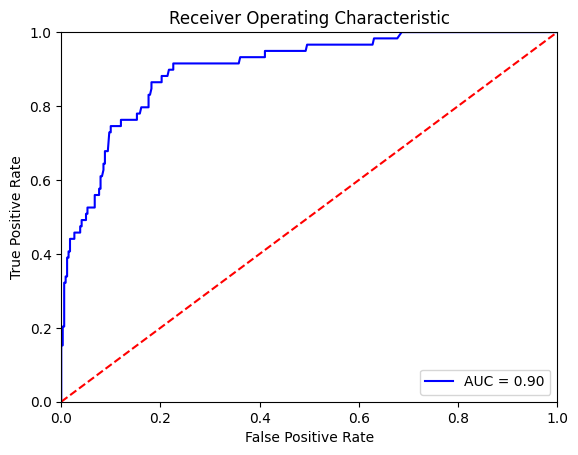

In [20]:
fpr, tpr, threshold = roc_curve(test['quality'], wine_rf_preds[:,1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [21]:
roc_auc

0.9014116009742035

In [23]:
confusion_matrix(test['quality'], (wine_rf_preds[:,1] > 0.5))

array([[334,   7],
       [ 33,  26]])

Let's look at feature importance scores to appraise what features matter most:

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'fixed acidity'),
  Text(1, 0, 'volatile acidity'),
  Text(2, 0, 'citric acid'),
  Text(3, 0, 'residual sugar'),
  Text(4, 0, 'chlorides'),
  Text(5, 0, 'free sulfur dioxide'),
  Text(6, 0, 'total sulfur dioxide'),
  Text(7, 0, 'density'),
  Text(8, 0, 'pH'),
  Text(9, 0, 'sulphates'),
  Text(10, 0, 'alcohol')])

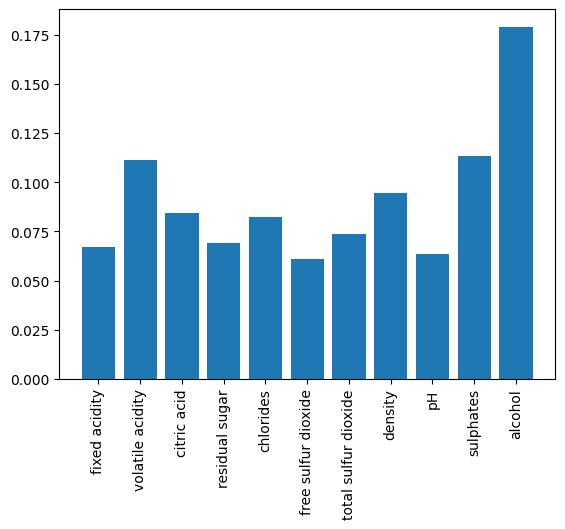

In [24]:
plt.bar(list(wine.columns)[0:11],wine_rf.feature_importances_)
plt.xticks(rotation=90)

No surprises there, these were also the most relevant scores in the regression and tree analysis.

Looks good. So, there are a few take-aways:

- The random forest seems to outperform the logistic regression (and, of course, also the single tree which was non-competitive). This is true in our test data, but this improvement in performance sustains over different cuts of the data set (i.e., different seeds).

- Tuning improved the performance a bit, but the baseline random forest already performed quite well!

### Gradient Boosting Model

Let's check the performance of the boosting model. Let's proceed similarly to what we did before, namely let's start with the baseline boosting model and then let's see what we can do to improve:

In [27]:
wine_boost_base = GradientBoostingClassifier(random_state=1)
wine_boost_base.fit(X_train, y_train)


GradientBoostingClassifier(random_state=1)

In [28]:
wine_boost_base_pred = wine_boost_base.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, wine_boost_base_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.8908991500571599

So, the AUC is is looking a little better here.

Let's see if we can improve some via tuning:

In [29]:
wine_boost_fast_many = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.075,random_state=1)
wine_boost_fast_many.fit(X_train, y_train)
wine_boost_fast_many_pred = wine_boost_fast_many.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, wine_boost_fast_many_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.8683051492577891

In [30]:
wine_boost_slow_many = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.025,random_state=1)
wine_boost_slow_many.fit(X_train, y_train)
wine_boost_slow_many_pred = wine_boost_slow_many.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, wine_boost_slow_many_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.8729813495731609

In [31]:
wine_boost_fast_few = GradientBoostingClassifier(n_estimators=400, learning_rate=0.075,random_state=1)
wine_boost_fast_few.fit(X_train, y_train)
wine_boost_fast_few_pred = wine_boost_fast_few.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, wine_boost_fast_few_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.8804850198466642

In [32]:
wine_boost_slow_few = GradientBoostingClassifier(n_estimators=400, learning_rate=0.025,random_state=1)
wine_boost_slow_few.fit(X_train, y_train)
wine_boost_slow_few_pred = wine_boost_slow_few.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, wine_boost_slow_few_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.8783100429557935

Let's try one more:

In [37]:
wine_boost_med_few = GradientBoostingClassifier(n_estimators=250, learning_rate=0.05,random_state=1)
wine_boost_med_few.fit(X_train, y_train)
wine_boost_med_few_pred = wine_boost_med_few.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, wine_boost_med_few_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.8845631015170463

So it seems like the medium learning rate with fewer trees performs the best out of these four variants. Of course, we could refine and check other parameters (e.g., by considering a more disciplined grid search). But, for now, let's roll with the model we strung together.

In [39]:
wine_boost = GradientBoostingClassifier(n_estimators=250, learning_rate=0.05,random_state=1)
wine_boost.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=250, random_state=1)

In [40]:
wine_boost_preds = wine_boost.predict_proba(X_test)

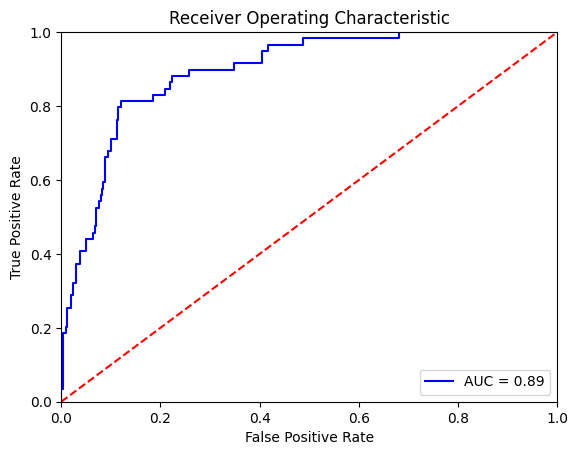

In [41]:
fpr, tpr, threshold = roc_curve(test['quality'], wine_boost_preds[:,1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
roc_auc

0.8940305184154282

In [44]:
confusion_matrix(test['quality'], (wine_boost_preds[:,1] > 0.5))

array([[326,  15],
       [ 35,  24]])

So, in the end, the performance of the boosting model is not quite in line with the random forest...

### AdaBoost

Finally, let's try the adaboost:

In [47]:
wine_ada_base = AdaBoostClassifier(random_state=1)
wine_ada_base.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

In [48]:
wine_ada_base_pred = wine_ada_base.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, wine_ada_base_pred[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.8717133058303096

So not great, and even basic attempts at tuning didn't improve it for me---though possibly this is feasible.